In [10]:
import os
import sys
import itertools
import logging
import copy

import Bio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

%load_ext autoreload
%autoreload 2
sys.path.append('..')
import medicc
import medicc.plot as mplot
import fstlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.CRITICAL)

# Define functions

In [19]:
def calc_distance_matrix(dfs, samples):

    distance_matrix = dict()
    for allele in ['cn_a', 'cn_b']:
        cur_distance_matrix = np.zeros((len(samples), len(samples)))

        for s1, s2 in itertools.combinations(np.arange(len(samples), dtype=int), r=2):
            cur_dist = np.sqrt(np.sum((dfs[samples[s1]][allele].values - dfs[samples[s2]][allele].values)**2))
            cur_distance_matrix[s1, s2] = cur_dist
            cur_distance_matrix[s2, s1] = cur_dist    

        distance_matrix[allele] = cur_distance_matrix
    distance_matrix['total'] = distance_matrix['cn_a'] + distance_matrix['cn_b']

    distance_matrix_loci = dict()
    for allele in ['cn_a', 'cn_b']:
        cur_distance_matrix = np.zeros((len(samples), len(samples)))

        for s1, s2 in itertools.combinations(np.arange(len(samples), dtype=int), r=2):
            cur_dist = np.sqrt(np.sum(dfs[samples[s1]]['length'].values * (dfs[samples[s1]][allele].values - dfs[samples[s2]][allele].values)**2))
            cur_distance_matrix[s1, s2] = cur_dist
            cur_distance_matrix[s2, s1] = cur_dist    

        distance_matrix_loci[allele] = cur_distance_matrix
    distance_matrix_loci['total'] = distance_matrix_loci['cn_a'] + distance_matrix_loci['cn_b']
    
    distance_matrix_L1 = dict()
    for allele in ['cn_a', 'cn_b']:
        cur_distance_matrix = np.zeros((len(samples), len(samples)))

        for s1, s2 in itertools.combinations(np.arange(len(samples), dtype=int), r=2):
            cur_dist = np.sum(np.abs(dfs[samples[s1]][allele].values - dfs[samples[s2]][allele].values))
            cur_distance_matrix[s1, s2] = cur_dist
            cur_distance_matrix[s2, s1] = cur_dist    

        distance_matrix_L1[allele] = cur_distance_matrix
    distance_matrix_L1['total'] = distance_matrix_L1['cn_a'] + distance_matrix_L1['cn_b']

    distance_matrix_L1_loci = dict()
    for allele in ['cn_a', 'cn_b']:
        cur_distance_matrix = np.zeros((len(samples), len(samples)))

        for s1, s2 in itertools.combinations(np.arange(len(samples), dtype=int), r=2):
            cur_dist = np.sum(dfs[samples[s1]]['length'].values * np.abs(dfs[samples[s1]][allele].values - dfs[samples[s2]][allele].values))
            cur_distance_matrix[s1, s2] = cur_dist
            cur_distance_matrix[s2, s1] = cur_dist    

        distance_matrix_L1_loci[allele] = cur_distance_matrix
    distance_matrix_L1_loci['total'] = distance_matrix_L1_loci['cn_a'] + distance_matrix_L1_loci['cn_b']
    
    
    return distance_matrix, distance_matrix_loci, distance_matrix_L1, distance_matrix_L1_loci

In [13]:
def calc_tree(distance_matrix, input_df, normal_name='diploid'):
    
    fst_path = os.path.join('../objects', 'wgd_asymm.fst')
    asymm_fst = fstlib.read(fst_path)
    chr_separator = 'X'
    normal_name = 'diploid'

    symbol_table = asymm_fst.input_symbols()

    ## Validate input
    logger.info("Validating input.")
    medicc.io.validate_input(input_df, symbol_table)

    ## Compile input data into FSAs stored in dictionaries
    logger.info("Compiling input sequences into FSAs.")
    FSA_dicts = [medicc.core.create_standard_fsa_dict_from_allele_column(input_df[c], symbol_table, chr_separator) for c in input_df]

    ## Calculate pairwise distances
    logger.info("Calculating pairwise distance matrices.")
    labels = input_df.index.get_level_values('sample_id').unique()
    pdms = distance_matrix

    ## Reconstruct a tree
    nj_tree = medicc.core.infer_tree_topology(pdms['total'], labels, diploid = normal_name)

#     medicc.tools.set_sequences_on_tree(nj_tree, FSA_dicts, input_df.columns)

    final_tree = copy.deepcopy(nj_tree)

#     ancestors = [medicc.reconstruct_ancestors(tree = final_tree, 
#                                                 samples_dict = fsa_dict, 
#                                                 model = asymm_fst, 
#                                                 normal_name = normal_name)
#                 for fsa_dict in FSA_dicts] 

    ## Update branch lengths with ancestors
#     medicc.tools.set_sequences_on_tree(final_tree, ancestors, input_df.columns)
#     medicc.core.update_branch_lengths(final_tree, asymm_fst, ancestors, normal_name)

    ## Create and write output data frame with ancestors
    output_df = input_df

    nj_tree.root_with_outgroup(normal_name)
    final_tree.root_with_outgroup(normal_name)
    return labels, pdms, nj_tree, final_tree, output_df

In [34]:
def plot_tree(tree_ax, input_tree, title=''):
    TREE_MARKER_SIZE = 40
    YLABEL_FONT_SIZE = 8
    YLABEL_TICK_SIZE = 6
    XLABEL_FONT_SIZE = 10
    XLABEL_TICK_SIZE = 8
    CHR_LABEL_SIZE = 8
    COL_MARKER_INTERNAL = '#1f77b4'
#     COL_MARKER_TERMINAL = 'black'
    COL_MARKER_TERMINAL = 'white'
    COL_MARKER_NORMAL = 'green'
    
    clade_colors = {}
    normal_name='diploid'
    for sample in [x.name for x in list(input_tree.find_clades(''))]:
        ## determine if sample is terminal
        is_terminal = True
        if input_tree is not None:
            matches = list(input_tree.find_clades(sample))
            if len(matches)>0:
                clade = matches[0]
                is_terminal = clade.is_terminal()
        ## determine if sample is normal
        is_normal = sample==normal_name
        clade_colors[sample] = COL_MARKER_TERMINAL
        if not is_terminal:
            clade_colors[sample] = COL_MARKER_INTERNAL
        if is_normal:
            clade_colors[sample] = COL_MARKER_NORMAL
    
    def label_func(label):
        label = str(label)
        if '_A' in label:
            return label.split('_A')[-1][2]
        else:
            return label
        
    tree_ax.axes.get_yaxis().set_visible(False)
    tree_ax.spines["right"].set_visible(False)
    tree_ax.spines["left"].set_visible(False)
    tree_ax.spines["top"].set_visible(False)
    tree_ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True, prune=None))
    tree_ax.xaxis.set_tick_params(labelsize=XLABEL_TICK_SIZE)
    tree_ax.xaxis.label.set_size(XLABEL_FONT_SIZE)
    tree_ax.set_title(title, x=0.01, y=0.99, ha='left', va='top', fontweight='bold', fontsize=16)
    x_posns = mplot._get_x_positions(input_tree)
    y_posns = mplot._get_y_positions(input_tree, adjust=True)
    mplot._draw_tree(input_tree, 
        x_posns, 
        y_posns, 
        label_func = label_func,
        branch_labels=None, 
#         branch_labels=lambda x:np.round(x.branch_length, 1) if x.name!='root' and x.name is not None else None, 
        marker_func = lambda x:(TREE_MARKER_SIZE, clade_colors[x.name]) if x.name is not None else None,
        axes=tree_ax)
    y_order = [x.name for x in y_posns if x.name is not None and x.name!='root'] ## as in tree

# Perform for Gundem et al. 2015 data

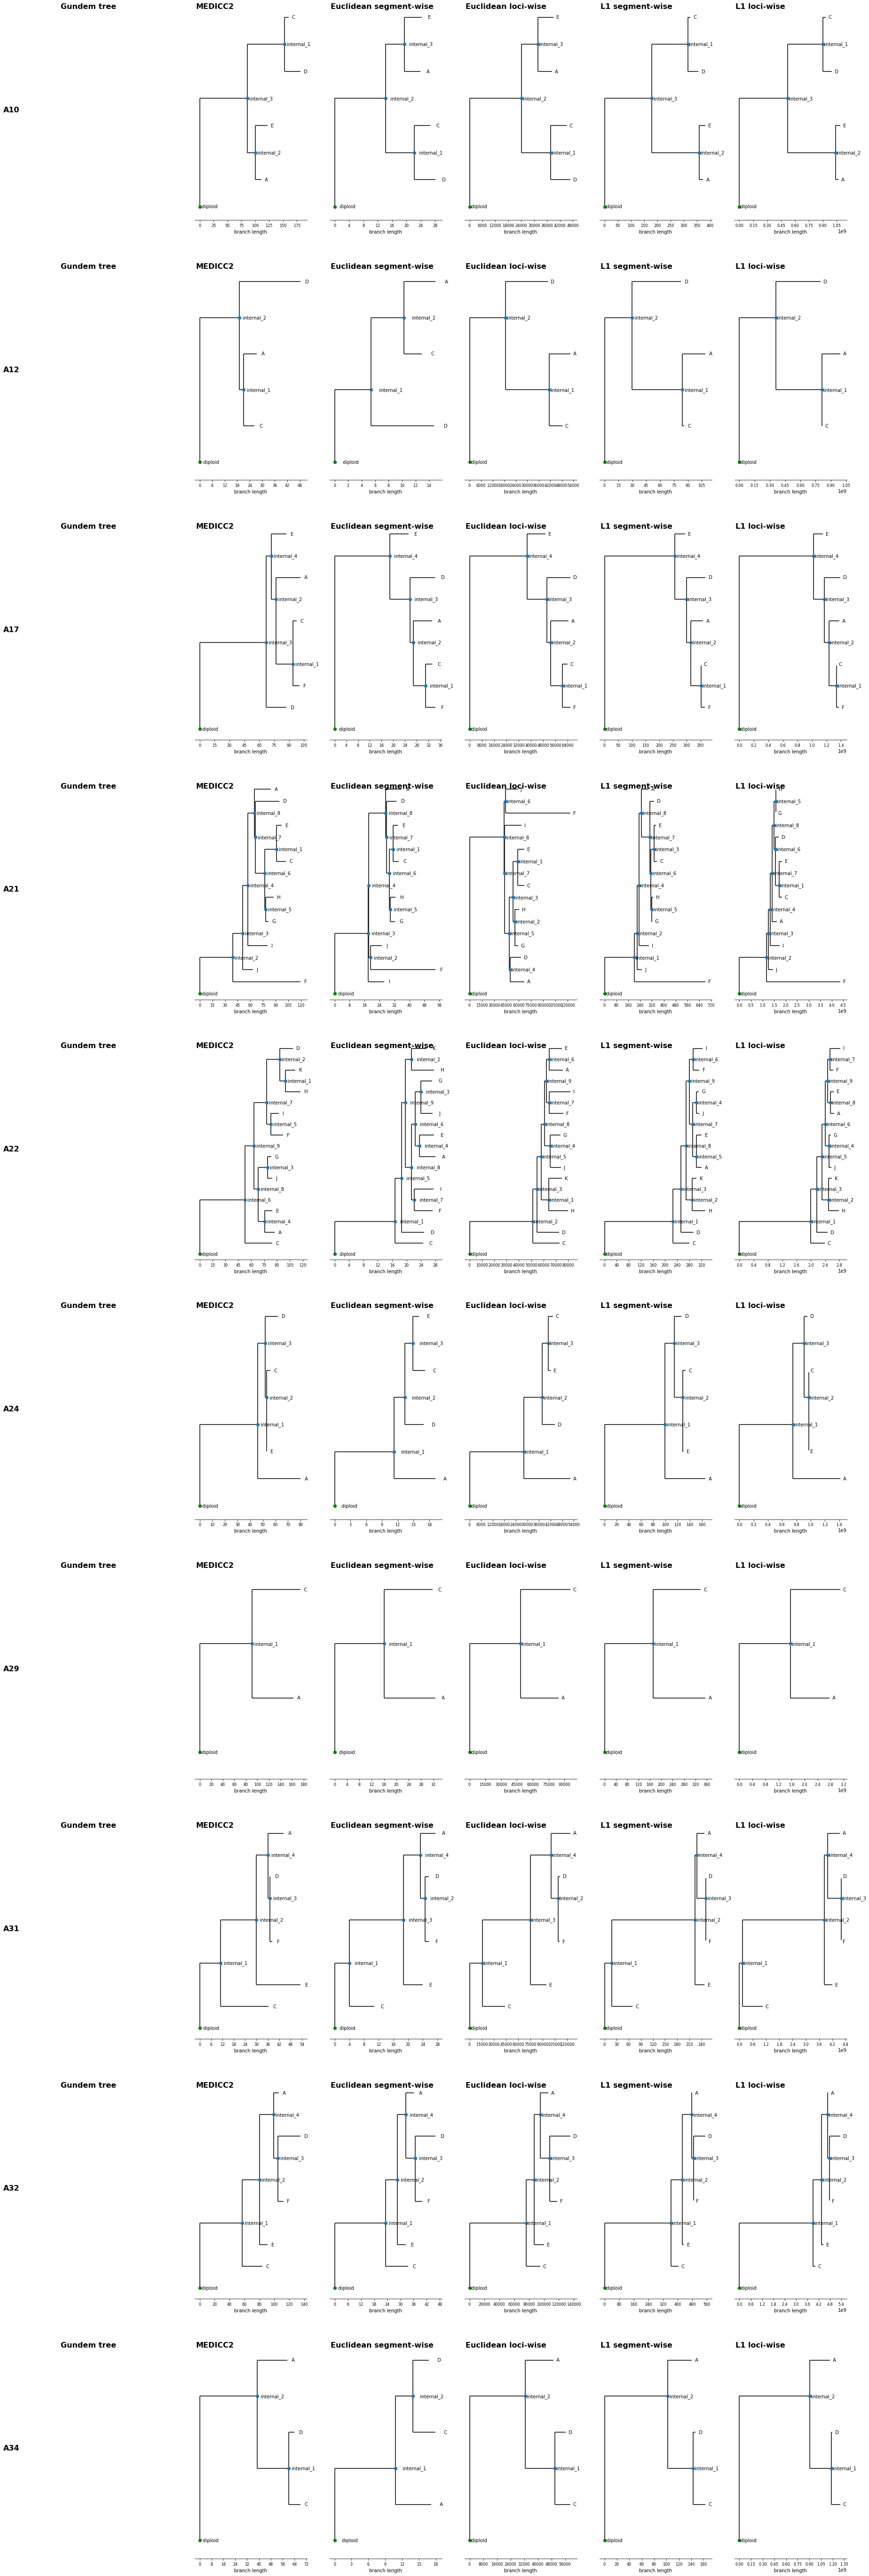

In [55]:
data_folder = "../../data/20210303_Gundem_phased_unphased_MEDICC2_input"
patients = np.sort([f.split('_')[2] for f in os.listdir(data_folder) if 'gundem_phased_data' in f])

fig, axs = plt.subplots(ncols=6, nrows=len(patients), figsize=(30, 10*len(patients)))

for patient, ax in zip(patients, axs):
    input_df = medicc.io.read_and_parse_input_data(
                    os.path.join(data_folder, "20210303_G_{}_gundem_phased_data_intersection_1mb_homdel_correct_df.txt".format(patient)),
                    'diploid',
                    'tsv',
                    'X',
                    ['cn_a','cn_b'])

    df = input_df.copy().astype(int)
    df.reset_index(inplace=True)

    dfs = {}
    for sample in df['sample_id'].unique():
    #     cur_sample = sample.split('_A')[-1][2]
        dfs[sample] = df.loc[df['sample_id']==sample].drop('sample_id', axis=1)

    dfs['diploid'] = dfs[list(dfs.keys())[0]].copy()
    dfs['diploid']['cn_a'] = 1
    dfs['diploid']['cn_b'] = 1

    samples = list(dfs.keys())
    patient_name = (samples[0].split('_')[1])[:3]

    for sample in samples:
        dfs[sample]['length'] = dfs[sample]['end'] - dfs[sample]['start']
        
    distance_matrix, distance_matrix_loci, distance_matrix_L1, distance_matrix_L1_loci = calc_distance_matrix(dfs, samples)

    medicc_tree = medicc.io.import_tree("../examples/output_gundem_et_al_2015/20210303_G_{}_gundem_phased_data_intersection_1mb_homdel_correct_df_final_tree.new".format(patient), 'diploid')
    plot_tree(ax[1], medicc_tree, 'MEDICC2')

    sample_labels, pdms, nj_tree, final_tree, output_df = calc_tree(distance_matrix, input_df)
    plot_tree(ax[2], final_tree, 'Euclidean segment-wise')

    sample_labels, pdms, nj_tree, final_tree_loci, output_df = calc_tree(distance_matrix_loci, input_df)
    plot_tree(ax[3], final_tree_loci, 'Euclidean loci-wise')
    
    sample_labels, pdms, nj_tree, final_tree_L1, output_df = calc_tree(distance_matrix_L1, input_df)
    plot_tree(ax[4], final_tree_L1, 'L1 segment-wise')

    sample_labels, pdms, nj_tree, final_tree_L1_loci, output_df = calc_tree(distance_matrix_L1_loci, input_df)
    plot_tree(ax[5], final_tree_L1_loci, 'L1 loci-wise')
    
    ax[0].set_title('Gundem tree', x=0.01, y=0.99, ha='left', va='top', fontweight='bold', fontsize=16)
    ax[0].set_axis_off()
    ax[0].text(-0.5, 0.5, patient_name, rotation=0, fontweight='bold', fontsize=16)

plt.savefig('../../results/_compare_medicc_euclidean_gundem.pdf', bbox_inches='tight', pad_inches=0)
plt.show()